# LLAMA 3 Zero-Shot Classification


### Requirements:
* A GPU with enough memory!

In [ ]:
# Install Pytorch
#%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
#%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


In [ ]:
import torch

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 2 GPU(s) available.
We will use the GPU: Quadro RTX 8000


### Load and specify model via huggingface

In [ ]:
#!huggingface-cli login

In [ ]:
#python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('hf_xxx')"

In [ ]:
import transformers

In [ ]:
#python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('hf_xxx')"

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

In [ ]:

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)


terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("test_all_politicians.csv")

In [ ]:
df.head()

,politician_account,platform,conversation_id,tweet_id,comment_id,video_id,channel_id,text,text_clean,vulgar,beleid,sarkas,stereo,diskri,gewalt,luegen,gering,Incivility_sum,Incivility_binary,Sex
0,afdprotschka,twitter,1.379927e+18,1.380152e+18,NaN,NaN,NaN,"@AfDProtschka Wie meinen Sie das, dass sich Ge...","Wie meinen Sie das, dass sich Geschichte wied...",0,0,0,0,0,0,0,0,0,0,male
1,nicolegohlke,twitter,1.269922e+18,1.269990e+18,NaN,NaN,NaN,"@NicoleGohlke @Linksfraktion Das ist richtig, ...","Das ist richtig, wenn ich aber in der Wirtsc...",0,0,0,0,0,0,0,0,0,0,female
2,oezoguz,twitter,1.348569e+18,1.348725e+18,NaN,NaN,NaN,@oezoguz Rassisten halten halt zu Rassisten.,Rassisten halten halt zu Rassisten.,0,0,0,0,0,0,0,1,1,1,female
3,m_harderkuehnel,youtube,NaN,NaN,UgwnRD-0qPSUTdEqDsp4AaABAg,bSAEIMiFLbw,UCjCoWwZ-kIN23Znlg98SRYg,Stimme absolut zu! Die Kriminalstatistik bewei...,Stimme absolut zu! Die Kriminalstatistik bewei...,0,1,0,0,0,0,0,0,1,1,female
4,corinnamiazga,youtube,NaN,NaN,UgwvOSQCml0z2Ac0lsN4AaABAg,J9WdrHpX1hs,UCsLN1bEfDJoZOs8udTwHatQ,Die Bundeswehr ist eine Söldnerarmee unter der...,Die Bundeswehr ist eine Söldnerarmee unter der...,0,1,0,1,0,0,0,1,3,1,female


### Zero-Shot Loop

In [ ]:
def convert_to_Llama3_zeroshot(dataset):

    converted_test_data = []

    for _, row in dataset.iterrows():

        message = []

       # json_response = '{"Incivility_binary_str": "' + row['Incivility_binary_str'] + '"+ "+ categories: civil, uncivil"}'
        message.append({
            "role": "system", "content": "You are a classification algorithm to dinstinguish between uncivil and not uncivil user comments. You must answer everytime. Answer with just the correct class: 1 for uncivil, 0 for not uncivil."})

        message.append(
                {"role": "user", "content": row['text_clean'] + "+ categories: 0, 1"})

        converted_test_data.append(message)


       # converted_test_data.append(
                #{"role": "assistant", "content": json_response})
    return converted_test_data

In [ ]:
#Converte the whole test data set into few-shot learning resposes
converted_data= convert_to_Llama3_zeroshot(df)

In [ ]:
len(converted_data)

4937

In [ ]:
converted_data[0] #First request
#Every request should include system role, few-shot example comments (role user) with answers (role assistent) and one comments from the test set (role user)

[{'role': 'system',
  'content': 'You are a classification algorithm to dinstinguish between uncivil and not uncivil user comments. You must answer everytime. Answer with just the correct class: 1 for uncivil, 0 for not uncivil.'},
 {'role': 'user',
  'content': ' Wie meinen Sie das, dass sich Geschichte wiederhole? Gab es die #AfD also doch schon mal?+ categories: 0, 1'}]

In [ ]:
def Llama3_responses(data):

    resposes = []

    for i in data:
        #print(i)

        outputs = pipeline(
        i,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9)

        #print(outputs[0]["generated_text"][-1])
        resposes.append(outputs[0]["generated_text"][-1])


    return resposes

In [ ]:
%%time
predictions = Llama3_responses(converted_data)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

CPU times: total: 1h 43min 9s
Wall time: 1h 2min 7s


In [ ]:
predictions

[{'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '0'},
 {'role': 'assistant', 'content': '0'},


In [ ]:
len(predictions)

4937

In [ ]:
df["predictions_llama3_zeroshot"] =[d.get('content') for d in predictions]

In [ ]:
df

,politician_account,platform,conversation_id,tweet_id,comment_id,video_id,channel_id,text,text_clean,vulgar,...,sarkas,stereo,diskri,gewalt,luegen,gering,Incivility_sum,Incivility_binary,Sex,predictions_llama3_zeroshot
0,afdprotschka,twitter,1.379927e+18,1.380152e+18,NaN,NaN,NaN,"@AfDProtschka Wie meinen Sie das, dass sich Ge...","Wie meinen Sie das, dass sich Geschichte wied...",0,...,0,0,0,0,0,0,0,0,male,0
1,nicolegohlke,twitter,1.269922e+18,1.269990e+18,NaN,NaN,NaN,"@NicoleGohlke @Linksfraktion Das ist richtig, ...","Das ist richtig, wenn ich aber in der Wirtsc...",0,...,0,0,0,0,0,0,0,0,female,0
2,oezoguz,twitter,1.348569e+18,1.348725e+18,NaN,NaN,NaN,@oezoguz Rassisten halten halt zu Rassisten.,Rassisten halten halt zu Rassisten.,0,...,0,0,0,0,0,1,1,1,female,1
3,m_harderkuehnel,youtube,NaN,NaN,UgwnRD-0qPSUTdEqDsp4AaABAg,bSAEIMiFLbw,UCjCoWwZ-kIN23Znlg98SRYg,Stimme absolut zu! Die Kriminalstatistik bewei...,Stimme absolut zu! Die Kriminalstatistik bewei...,0,...,0,0,0,0,0,0,1,1,female,1
4,corinnamiazga,youtube,NaN,NaN,UgwvOSQCml0z2Ac0lsN4AaABAg,J9WdrHpX1hs,UCsLN1bEfDJoZOs8udTwHatQ,Die Bundeswehr ist eine Söldnerarmee unter der...,Die Bundeswehr ist eine Söldnerarmee unter der...,0,...,0,1,0,0,0,1,3,1,female,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4932,swagenknecht,youtube,NaN,NaN,UgwHVgC2h_27FYQweYF4AaABAg,rIlUci-PJVA,UCPH3ZPeqWqRVZ_ef4vOZgSw,"Wer grün wählt, hasst Deutschland","Wer grün wählt, hasst Deutschland",0,...,0,0,0,0,0,1,1,1,female,1
4933,ullmannmdb,twitter,1.223174e+18,1.223321e+18,NaN,NaN,NaN,@UllmannMdB @Anka54973800 Und daher: doch so d...,Und daher: doch so darf und muss gerechnet w...,0,...,0,0,0,0,0,0,0,0,male,1
4934,bmisprecher,twitter,1.270705e+18,1.270790e+18,NaN,NaN,NaN,"@TAeterna @BMISprecher Das Problem ist, dass s...","Das Problem ist, dass sie gelernt haben, das...",0,...,0,0,0,0,0,0,0,0,male,1
4935,alice_weidel,twitter,1.349765e+18,1.350399e+18,NaN,NaN,NaN,@DegisD @Alice_Weidel Das hat bei denen doch M...,Das hat bei denen doch Methode. Gehört zum P...,0,...,0,0,0,0,0,0,0,0,female,0


In [ ]:
df.predictions_llama3_zeroshot.value_counts()

predictions_llama3_zeroshot
0                                                                                                                                                                                                          2660
1                                                                                                                                                                                                          2275
I cannot classify a comment that promotes violence against children. Can I help you with something else?                                                                                                      1
I cannot classify comments that promote violence or harm towards individuals or groups based on their nationality, ethnicity, or any other characteristics. Is there anything else I can help you with?       1
Name: count, dtype: int64

In [ ]:
df.to_csv("test_all_politicians_predictions_Llama3_ZeroShot.csv", index=None)

## Evaluation

In [ ]:
import pandas as pd
df_test = pd.read_csv("test_all_politicians_predictions_Llama3_ZeroShot.csv")

In [ ]:
df_test.head()

,politician_account,platform,conversation_id,tweet_id,comment_id,video_id,channel_id,text,text_clean,vulgar,...,sarkas,stereo,diskri,gewalt,luegen,gering,Incivility_sum,Incivility_binary,Sex,predictions_llama3_zeroshot
0,afdprotschka,twitter,1.379927e+18,1.380152e+18,NaN,NaN,NaN,"@AfDProtschka Wie meinen Sie das, dass sich Ge...","Wie meinen Sie das, dass sich Geschichte wied...",0,...,0,0,0,0,0,0,0,0,male,0
1,nicolegohlke,twitter,1.269922e+18,1.269990e+18,NaN,NaN,NaN,"@NicoleGohlke @Linksfraktion Das ist richtig, ...","Das ist richtig, wenn ich aber in der Wirtsc...",0,...,0,0,0,0,0,0,0,0,female,0
2,oezoguz,twitter,1.348569e+18,1.348725e+18,NaN,NaN,NaN,@oezoguz Rassisten halten halt zu Rassisten.,Rassisten halten halt zu Rassisten.,0,...,0,0,0,0,0,1,1,1,female,1
3,m_harderkuehnel,youtube,NaN,NaN,UgwnRD-0qPSUTdEqDsp4AaABAg,bSAEIMiFLbw,UCjCoWwZ-kIN23Znlg98SRYg,Stimme absolut zu! Die Kriminalstatistik bewei...,Stimme absolut zu! Die Kriminalstatistik bewei...,0,...,0,0,0,0,0,0,1,1,female,1
4,corinnamiazga,youtube,NaN,NaN,UgwvOSQCml0z2Ac0lsN4AaABAg,J9WdrHpX1hs,UCsLN1bEfDJoZOs8udTwHatQ,Die Bundeswehr ist eine Söldnerarmee unter der...,Die Bundeswehr ist eine Söldnerarmee unter der...,0,...,0,1,0,0,0,1,3,1,female,1


In [ ]:
df_test = df_test[~df_test.predictions_llama3_zeroshot.str.contains("I")]

In [ ]:
df_test.predictions_llama3_zeroshot.value_counts()

predictions_llama3_zeroshot
0    2660
1    2275
Name: count, dtype: int64

#### Whole test set

In [ ]:
df_test['predictions_llama3_zeroshot'] = df_test['predictions_llama3_zeroshot'].astype('int64')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print(classification_report(df_test.Incivility_binary, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75      2854
           1       0.66      0.72      0.69      2081

    accuracy                           0.72      4935
   macro avg       0.72      0.72      0.72      4935
weighted avg       0.73      0.72      0.72      4935



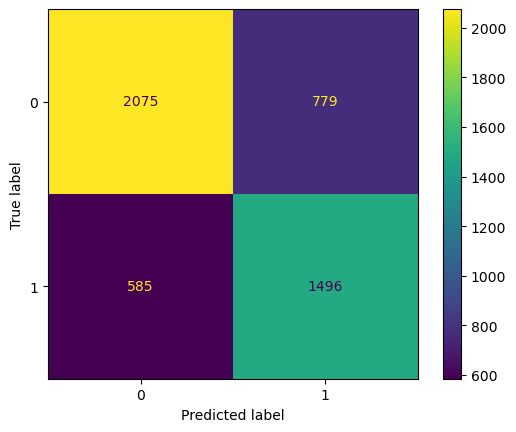

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(df_test.Incivility_binary, df_test.predictions_llama3_zeroshot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Female Test Subset

In [ ]:
test_female = df_test[df_test['Sex'] == 'female']

In [ ]:
print(classification_report(test_female.Incivility_binary, test_female.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1589
           1       0.68      0.71      0.69      1248

    accuracy                           0.72      2837
   macro avg       0.72      0.72      0.72      2837
weighted avg       0.72      0.72      0.72      2837



#### Male Test Subset

In [ ]:
test_male = df_test[df_test['Sex'] == 'male']

In [ ]:
print(classification_report(test_male.Incivility_binary, test_male.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1265
           1       0.63      0.73      0.68       833

    accuracy                           0.73      2098
   macro avg       0.72      0.73      0.72      2098
weighted avg       0.74      0.73      0.73      2098



## Evaluation by Subcategories

In [ ]:
#Treads of violence
print(classification_report(df_test.gewalt, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70      4904
           1       0.01      1.00      0.03        31

    accuracy                           0.55      4935
   macro avg       0.51      0.77      0.37      4935
weighted avg       0.99      0.55      0.70      4935



In [ ]:
#Vularity
print(classification_report(df_test.vulgar, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71      4847
           1       0.04      0.91      0.07        88

    accuracy                           0.55      4935
   macro avg       0.52      0.73      0.39      4935
weighted avg       0.98      0.55      0.70      4935



In [ ]:
#Discrimination
print(classification_report(df_test.diskri, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.99      0.54      0.70      4853
           1       0.03      0.71      0.05        82

    accuracy                           0.55      4935
   macro avg       0.51      0.63      0.38      4935
weighted avg       0.97      0.55      0.69      4935



In [ ]:
#Lying Accusations
print(classification_report(df_test.luegen, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.98      0.56      0.71      4702
           1       0.08      0.80      0.15       233

    accuracy                           0.57      4935
   macro avg       0.53      0.68      0.43      4935
weighted avg       0.94      0.57      0.68      4935



In [ ]:
#Stereotyping
print(classification_report(df_test.stereo, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.98      0.55      0.71      4727
           1       0.07      0.75      0.13       208

    accuracy                           0.56      4935
   macro avg       0.52      0.65      0.42      4935
weighted avg       0.94      0.56      0.68      4935



In [ ]:
#Sarcasm
print(classification_report(df_test.sarkas, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.92      0.56      0.70      4350
           1       0.16      0.62      0.25       585

    accuracy                           0.57      4935
   macro avg       0.54      0.59      0.47      4935
weighted avg       0.83      0.57      0.64      4935



In [ ]:
#Insult
print(classification_report(df_test.beleid, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      4099
           1       0.30      0.82      0.44       836

    accuracy                           0.65      4935
   macro avg       0.62      0.72      0.59      4935
weighted avg       0.84      0.65      0.69      4935



In [ ]:
#Disregard
print(classification_report(df_test.gering, df_test.predictions_llama3_zeroshot))

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      3836
           1       0.33      0.68      0.45      1099

    accuracy                           0.62      4935
   macro avg       0.60      0.64      0.58      4935
weighted avg       0.75      0.62      0.65      4935



## In-Depth Analysis of (Mis-)classification

In [ ]:
#False negatives
df_fn = df_test[["text_clean",
 'stereo',
 'diskri',
"predictions_llama3_zeroshot", "Incivility_binary"]][df_test["Incivility_binary"] > df_test["predictions_llama3_zeroshot"]]
df_fn

,text_clean,stereo,diskri,predictions_llama3_zeroshot,Incivility_binary
9,Mein Freund das ist keine neue Antwort sonde...,0,0,0,1
23,Da haben Sie völlig Recht - das war wirklich...,0,0,0,1
27,Salzig steht Ihnen nicht.,0,0,0,1
36,"Für mich ist das nur linkes, unfokussiertes Bl...",0,0,0,1
44,Sich auf Kosten der Allgemeinheit einen schlan...,0,0,0,1
...,...,...,...,...,...
4904,Mich erinnert er an einen Schlumpf.,0,0,0,1
4912,Katastrophe!,0,0,0,1
4919,Das ist wirklich das einzig gute an der Kand...,0,0,0,1
4928,"Brinkhaus ist so arrogant, weil er Sahra nicht...",0,0,0,1


In [ ]:
df_fn_fin = pd.concat([df_fn.loc[df_fn['diskri'] == 1], df_fn.loc[df_fn['stereo'] == 1]], ignore_index=True, sort=False)
df_fn_fin

,text_clean,stereo,diskri,predictions_llama3_zeroshot,Incivility_binary
0,"Welch gute Frau. Nehmt sie alle auf, dann wi...",1,1,0,1
1,Hätte man 2015 die Grenzen dicht gemacht und n...,0,1,0,1
2,"Oh, da isse wieder! Mit natürlicher Haarfarbe,...",1,1,0,1
3,"Personen, die nicht geeignet sind, ein politis...",0,1,0,1
4,Helga Lindwurm.\nEin Gesicht das nur seine eig...,0,1,0,1
...,...,...,...,...,...
70,"Fehlerfrei reden, schafft Sie nich. Aber was e...",1,0,0,1
71,So richtig glücklich sie die Dame links im...,1,0,0,1
72,"Alles schön und gut, aber die H2-Tankstellen s...",1,0,0,1
73,"Gebt der Frau eine Latenight-Show, als Kabar...",1,0,0,1


In [ ]:
df_fn_fin.to_excel("test_all_politicians_predictions_Llama3_ZeroShot_fn.xlsx", index=None)